# Лабораторная работа №4. Задание
В задании Вам предлагается разобраться с тем, как работает дерево решений, на игрушечном примере, затем обучить и настроить деревья в задаче классификации на данных Adult репозитория UCI

Подключаем необходимые библиотеки

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score

## Часть 1. Игрушечный набор данных "девушка в баре"

Цель –  "на пальцах", с помощью игрушечной задачи классификации разобраться в том, как работают деревья решений. Само по себе дерево решений – довольно слабый алгоритм, но основанные на нем алгоритмы случайного леса и градиентного бустинга - пожалуй, лучшее, что есть на сегодняшний день (в задачах, где можно обойтись без нейронных сетей). Поэтому разобраться в том, как работает дерево решений, полезно.

Рассмотрим игрушечную задачу бинарной классификации: поедет ли с молодым человеком девушка из бара? Это будет зависеть от его внешности и красноречия, крепости предлагаемых напитков и, как это ни меркантильно, от количества потраченных в баре денег.

<img src='img/toy_data.png'>

### Создание набора данных

In [2]:
# Создание датафрейма с dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Внешность', 'Алкоголь_в_напитке',
            'Уровень_красноречия', 'Потраченные_деньги']

Обучающая выборка

In [4]:
df_train = {}
df_train['Внешность'] = ['приятная', 'приятная', 'приятная', 'отталкивающая',
                         'отталкивающая', 'отталкивающая', 'приятная'] 
df_train['Алкоголь_в_напитке'] = ['да', 'да', 'нет', 'нет', 'да', 'да', 'да']
df_train['Уровень_красноречия'] = ['высокий', 'низкий', 'средний', 'средний', 'низкий',
                                   'высокий', 'средний']
df_train['Потраченные_деньги'] = ['много', 'мало', 'много', 'мало', 'много',
                                  'много', 'много']
df_train['Поедет'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Поедет,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_низкий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,0,False,True,True,False,True,False,False,False,True
1,1,False,True,True,False,False,True,False,True,False
2,0,False,True,False,True,False,False,True,False,True
3,1,True,False,False,True,False,False,True,True,False
4,1,True,False,True,False,False,True,False,False,True
5,0,True,False,True,False,True,False,False,False,True
6,0,False,True,True,False,False,False,True,False,True


Тестовая выборка

In [5]:
df_test = {}
df_test['Внешность'] = ['приятная', 'приятная', 'отталкивающая'] 
df_test['Алкоголь_в_напитке'] = ['нет', 'да', 'да']
df_test['Уровень_красноречия'] = ['средний', 'высокий', 'средний']
df_test['Потраченные_деньги'] = ['много', 'мало', 'много']
df_test = create_df(df_test, features)
df_test

,Внешность_отталкивающая,Внешность_приятная,Алкоголь_в_напитке_да,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий,Уровень_красноречия_средний,Потраченные_деньги_мало,Потраченные_деньги_много
0,False,True,False,True,False,True,False,True
1,False,True,True,False,True,False,True,False
2,True,False,True,False,False,True,False,True


In [6]:
# Некоторые значения признаков есть в тесте, но нет в трейне и наоборот
y = df_train['Поедет']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Потраченные_деньги_много,Алкоголь_в_напитке_да,Уровень_красноречия_средний,Потраченные_деньги_мало,Внешность_приятная,Внешность_отталкивающая,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий
0,True,True,False,False,True,False,False,True
1,False,True,False,True,True,False,False,False
2,True,False,True,False,True,False,True,False
3,False,False,True,True,False,True,True,False
4,True,True,False,False,False,True,False,False
5,True,True,False,False,False,True,False,True
6,True,True,True,False,True,False,False,False


In [7]:
df_test

,Потраченные_деньги_много,Алкоголь_в_напитке_да,Уровень_красноречия_средний,Потраченные_деньги_мало,Внешность_приятная,Внешность_отталкивающая,Алкоголь_в_напитке_нет,Уровень_красноречия_высокий
0,True,False,True,False,True,False,True,False
1,False,True,False,True,True,False,False,True
2,True,True,True,False,False,True,False,False


Постройте от руки (или в графическом редакторе) дерево решений для этого набора данных. Дополнительно (для желающих) – можете сделать отрисовку дерева и написать код для построения всего дерева с помощью **GraphViz**.

**Вопрос 1.** Какова энтропия начальной системы ($S_0$)? Под состояниями системы понимаем значения признака "Поедет" – 0 или 1 (то есть всего 2 состояния).

In [8]:
# Ваш код здесь
import math
p1 = 3/7
p2 = 4/7
print("Entropy: ", -p1*math.log2(p1)-p2*math.log2(p2))

Entropy:  0.9852281360342515


**Вопрос 2.** Рассмотрим разбиение обучающей выборки по признаку "Внешность\_приятная". Какова энтропия  $S_1$ левой группы, тех, у кого внешность приятная, и правой группы – $S_2$? Каков прирост информации  при данном разбиении (IG)? 

In [9]:
# Ваш код здесь

Постройте с помощью `sklearn` дерево решений, обучив его на обучающей выборке. Глубину можно не ограничивать.

In [10]:
# Ваш код здесь
dtc = DecisionTreeClassifier()
dtc.fit(df_train, y)

DecisionTreeClassifier()

**Дополнительно:** отобразите дерево с помощью graphviz. Можно использовать `pydot` или, например, [онлайн-сервис](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.

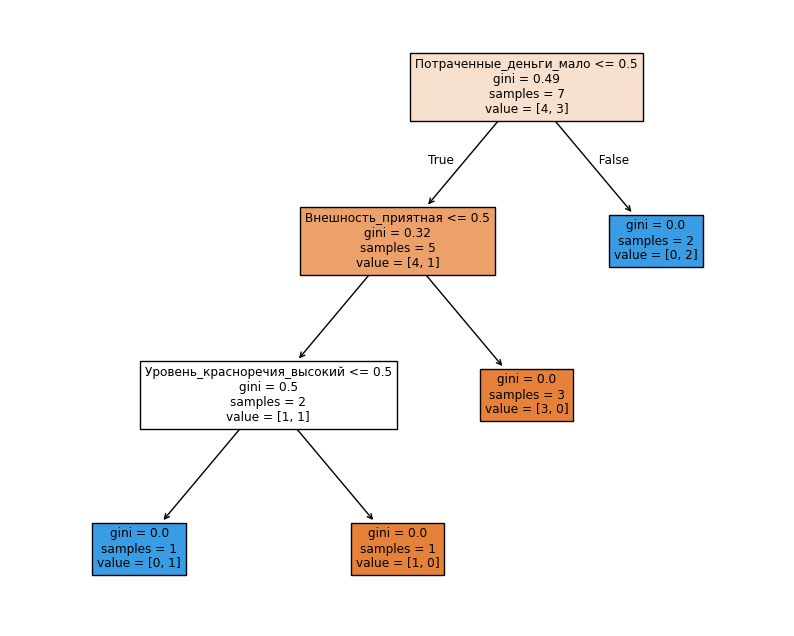

In [11]:
# Ваш код здесь
from sklearn import tree

fig = plt.figure()
_ = tree.plot_tree(
    dtc,
    feature_names=df_train.columns,
    filled=True
)

## Часть 2. Функции для расчета энтропии и прироста информации

Пример для проверки: 9 синих шариков и 11 желтых. Пусть шарик находится в состоянии "1", если он синий и "0" – если он желтый.

In [12]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

![png](img/decision_tree3.png)

Дальше пусть шарики разбиваются на 2 группы
![png](img/decision_tree4.png)

In [13]:
# две группы
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 синих и 5 желтых
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 синий и 6 желтых

Реализуйте функцию для расчета энтропии Шеннона.

In [14]:
def entropy(a_list):
    
    # Ваш код здесь
    pass

# Проверка:
print(entropy(balls)) # 9 синих и 11 желтых
print(entropy(balls_left)) # 8 синих и 5 желтых
print(entropy(balls_right)) # 1 синий и 6 желтых
print(entropy([1,2,3,4,5,6])) # энтропия игральной кости с несмещенным центром тяжести

None
None
None
None


**Вопрос 3.** Чему равна энтропия состояния, заданного списком `balls_left`?

**Вопрос 4.** Чему равна энтропия "честной" монетки?

In [15]:
# расчет прироста информации

def information_gain(root, left, right):
    ''' root - изначальный набор данных, left и right два разбиения изначального набора'''
    
    # Ваш код здесь
    pass

**Вопрос 5.** Каков прирост информации при разделении выборки на `balls_left` и `balls_right`?

In [16]:
# Ваш код здесь

In [17]:
def best_feature_to_split(X, y):
    ''' Выводит прирост информации при разбиении по каждому признаку'''
    
    # Ваш код здесь
    pass

**Опционально:**

 - реализуйте алгоритм построения дерева за счет рекурсивного вызова функции `best_feature_to_split`
 - нарисуйте полученное дерево

## Часть 3. Набор данных "Adult"
**Описание набора:**
**[Набор](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) данных UCI Adult** (качать не надо, все есть в репозитории): классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более \$ 50 000 в год.

Описание признаков: 

**Age** – возраст, количественный признак  
**Workclass** – тип работодателя, количественный признак  
**fnlwgt** – итоговый вес обьекта, количественный признак    
**Education** – уровень образования, качественный признак  
**Education_Num** – количество лет обучения, количественный признак  
**Martial_Status** – семейное положение, категориальный признак  
**Occupation** – профессия, категориальный признак  
**Relationship** – тип семейных отношений, категориальный признак    
**Race** – раса, категориальный признак  
**Sex** – пол, качественный признак  
**Capital_Gain** – прирост капитала, количественный признак  
**Capital_Loss** – потери капитала, количественный признак  
**Hours_per_week** – количество часов работы в неделю, количественный признак  
**Country** – страна, категориальный признак  
   
Целевая переменная: **Target** – уровень заработка, категориальный (бинарный) признак

Считываем обучающую и тестовую выборки.

In [18]:
data_train = pd.read_csv('../data/adult_train.csv', sep=';') 

FileNotFoundError: [Errno 2] No such file or directory: '../data/adult_train.csv'

In [ ]:
data_train.tail()

In [ ]:
data_test = pd.read_csv('../data/adult_test.csv', sep=';') 

In [ ]:
data_test.tail()

In [ ]:
# необходимо убрать строки с неправильными метками в тестовой выборке
data_test = data_test[(data_test['Target'] == ' >50K.') 
                      | (data_test['Target']==' <=50K.')]

# перекодируем target в числовое поле
data_train.at[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.at[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.at[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.at[data_test['Target'] == ' >50K.', 'Target'] = 1

Первичный анализ данных.

In [ ]:
data_test.describe(include='all').T

In [ ]:
data_train['Target'].value_counts()

In [ ]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

Проверяем типы данных.

In [ ]:
data_train.dtypes

In [ ]:
data_test.dtypes

Выяснилось, что в тесте возраст отнесен к типу object, необходимо это исправить.

In [ ]:
data_test['Age'] = data_test['Age'].astype(int)

Также приведем показатели типа float в int для соответствия train и test выборок.

In [ ]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

Заполним пропуски в количественных полях медианными значениями, а в категориальных – наиболее часто встречающимся значением

In [ ]:
# выделим в выборках категориальные и числовые поля

categorical_columns_train = [c for c in data_train.columns 
                             if data_train[c].dtype.name == 'object']
numerical_columns_train = [c for c in data_train.columns 
                           if data_train[c].dtype.name != 'object']

categorical_columns_test = [c for c in data_test.columns 
                            if data_test[c].dtype.name == 'object']
numerical_columns_test = [c for c in data_test.columns 
                          if data_test[c].dtype.name != 'object']

print('categorical_columns_test:', categorical_columns_test)
print('categorical_columns_train:', categorical_columns_train)
print('numerical_columns_test:', numerical_columns_test)
print('numerical_columns_train:', numerical_columns_train)

In [ ]:
# заполним пропуски

for c in categorical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].mode())
for c in categorical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].mode())
    
for c in numerical_columns_train:
    data_train[c] = data_train[c].fillna(data_train[c].median())
for c in numerical_columns_test:
    data_test[c] = data_test[c].fillna(data_train[c].median())    

Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода `pandas get_dummies`.

In [ ]:
data_train = pd.concat([data_train, pd.get_dummies(data_train['Workclass'], 
                                                   prefix="Workclass"),
                      pd.get_dummies(data_train['Education'], prefix="Education"),
                      pd.get_dummies(data_train['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_train['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_train['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_train['Race'], prefix="Race"),
                      pd.get_dummies(data_train['Sex'], prefix="Sex"),
                      pd.get_dummies(data_train['Country'], prefix="Country")],
                     axis=1)

data_test = pd.concat([data_test, pd.get_dummies(data_test['Workclass'], prefix="Workclass"),
                      pd.get_dummies(data_test['Education'], prefix="Education"),
                      pd.get_dummies(data_test['Martial_Status'], prefix="Martial_Status"),
                      pd.get_dummies(data_test['Occupation'], prefix="Occupation"),
                      pd.get_dummies(data_test['Relationship'], prefix="Relationship"),
                      pd.get_dummies(data_test['Race'], prefix="Race"),
                      pd.get_dummies(data_test['Sex'], prefix="Sex"),
                      pd.get_dummies(data_test['Country'], prefix="Country")],
                     axis=1)

In [ ]:
data_train.drop(['Workclass', 'Education', 'Martial_Status',
                 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'],
                axis=1, inplace=True)
data_test.drop(['Workclass', 'Education', 'Martial_Status', 'Occupation', 
                'Relationship', 'Race', 'Sex', 'Country'],
               axis=1, inplace=True)

In [ ]:
data_test.describe(include='all').T

In [ ]:
set(data_train.columns) - set(data_test.columns)

In [ ]:
data_train.shape, data_test.shape

В тестовой выборке не оказалось Голландии. Заведем необходимый признак из нулей.

In [ ]:
data_test['Country_ Holand-Netherlands'] = np.zeros([data_test.shape[0], 1])

In [ ]:
set(data_train.columns) - set(data_test.columns)

In [ ]:
data_train.head(2)

In [ ]:
data_test.head(2)

In [ ]:
X_train=data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test=data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

### 3.1. Дерево решений без настройки параметров 

Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`) максимальной глубины 3 и получите качество на тесте. Используйте параметр `random_state` = 17 для воспроизводимости результатов.

In [ ]:
tree = # Ваш код здесь
tree.fit # Ваш код здесь

Сделайте с помощью полученной модели прогноз для тестовой выборки.

In [ ]:
tree_predictions = tree.predict # Ваш код здесь

In [ ]:
accuracy_score # Ваш код здесь

**Вопрос 6.** Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 3 и random_state = 17?

### 3.2. Дерево решений с настройкой параметров 

Обучите на имеющейся выборке дерево решений (`DecisionTreeClassifier`, опять `random_state` = 17 ). Максимальную глубину настройте на кросс-валидации с помощью `GridSearchCV`. Проведите 5-кратную кросс-валидацию.

In [ ]:
tree_params = {'max_depth': range(2,11)}

locally_best_tree = GridSearchCV # Ваш код здесь                      

locally_best_tree.fit # Ваш код здесь

In [ ]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Обучите на имеющейся выборке дерево решений максимальной глубины 9 (это лучшее значение `max_depth` в моем случае) и   оцените долю правильных ответов на тесте. Используйте параметр random_state = 17 для воспроизводимости результатов.

In [ ]:
tuned_tree = # Ваш код здесь
tuned_tree.fit # Ваш код здесь
tuned_tree_predictions = tuned_tree.predict # Ваш код здесь
accuracy_score # Ваш код здесь

**Вопрос 7.**  </font> Какова доля правильных ответов дерева решений на тестовой выборке при максимальной глубине дерева = 9 и random_state = 17?

Использованы материалы **"Открытого курса по машинному обучению"**. Авторы: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий и Data Scientist в Segmento Екатерина Демидова. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.